# Object Recognition exploiting CNN

**CIFAR-10**  is an established computer-vision dataset used for object recognition. **It is a subset of the 80
million tiny images dataset and consists of 60,000 32x32 color images containing one of 10 object classes, 
with 6000 images per class**. It was collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton.

For this guide, I'm referring to this online guide: https://www.kaggle.com/code/datajameson/cifar-10-object-recognition-cnn-explained/notebook

You can also download the dataset from that notebook.

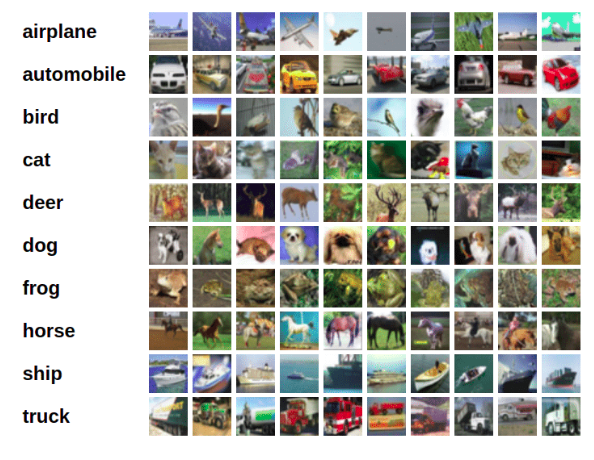

In [1]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor,ToPILImage
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid
import torch.nn as nn
import torch.nn.functional as F

### Dataset

 It contains **train and test** folders, containing **the training set (50000 images)** and **test set (10000 images)** respectively. **Each of them contains 10 folders, one for each class of images**.

In [ ]:
print(os.listdir('../Object Detenction/input/cifar10'))

['labels.txt', 'test', 'train']


In [ ]:
classes= os.listdir('../Object Detenction/input/cifar10/train')
print(classes)

['ship', 'bird', 'horse', 'deer', 'dog', 'truck', 'airplane', 'automobile', 'cat', 'frog']


These are the objects that the model will be able to identify given input images.

Let's exploit ```ImageFolder``` from ```torchvision.datasets```, which organizes images by class directories and turns each image into a tensor using ```ToTensor()```. This is a good approach for working with the CIFAR-10 dataset.

It is expected that images are organized into subfolders, where each folder represents a different class:

```
cifar10/
    train/
        bird/
        cat/
        dog/
        ship/
        ...
```

The ```ImageFolder``` class will read all the images in the subfolders and **automatically assign a numeric label to each image** based on the subfolder it is located in.

In [ ]:
data_dir = '../Object Detenction/input/cifar10'
dataset = ImageFolder(data_dir+'/train', transform=ToTensor())

```transform=ToTensor()``` applies a transformation to each image in the dataset. What the function does is converting the loaded images (which are usually in the PIL Image or numpy ndarray format) into a PyTorch tensor. **A tensor is a multidimensional matrix-like object**.

Images that normally have pixel values ​​between 0 and 255 are converted to values ​​between 0 and 1, i.e. **normalized**. The resulting tensor will have **a form of (C, H, W)** where:
- **C is the number of channels** (e.g. 3 for RGB images),
- **H is the height**,
- **W is the width**.

In [5]:
img, label= dataset[0]
print(img.shape,label)
img

torch.Size([3, 32, 32]) 0


tensor([[[0.8588, 0.8588, 0.8627,  ..., 0.8510, 0.8471, 0.8392],
         [0.8667, 0.8667, 0.8745,  ..., 0.8588, 0.8549, 0.8471],
         [0.8667, 0.8667, 0.8745,  ..., 0.8588, 0.8549, 0.8471],
         ...,
         [0.8980, 0.9020, 0.9098,  ..., 0.8980, 0.8902, 0.8863],
         [0.8471, 0.8549, 0.8706,  ..., 0.8980, 0.8902, 0.8824],
         [0.7608, 0.7490, 0.7725,  ..., 0.8980, 0.8902, 0.8824]],

        [[0.9333, 0.9333, 0.9373,  ..., 0.9176, 0.9137, 0.9059],
         [0.9412, 0.9412, 0.9490,  ..., 0.9294, 0.9216, 0.9137],
         [0.9412, 0.9412, 0.9490,  ..., 0.9255, 0.9216, 0.9137],
         ...,
         [0.9608, 0.9569, 0.9569,  ..., 0.9412, 0.9412, 0.9412],
         [0.9020, 0.9098, 0.9255,  ..., 0.9412, 0.9412, 0.9373],
         [0.8157, 0.8039, 0.8275,  ..., 0.9412, 0.9412, 0.9373]],

        [[0.9608, 0.9608, 0.9647,  ..., 0.9490, 0.9412, 0.9412],
         [0.9686, 0.9686, 0.9765,  ..., 0.9608, 0.9529, 0.9490],
         [0.9686, 0.9686, 0.9765,  ..., 0.9569, 0.9529, 0.

The line ```img, label = dataset[0]``` **accesses the first image and its label (class) from the dataset**.
After ToTensor() function applied, the image ```img``` is a tensor with parameters (C, H, W) and ```label``` is the integer representing the image class (for example, 0 for 'airplane', 1 for 'car', etc.)

```torch.Size([3, 32, 32]) 0```: it means that the image has 3 channels (RGB) and a resolution of 32x32 pixels, and 0 which corresponds to the first class (airplane).

In [6]:
print(dataset.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In PyTorch, when you load an image with ```ToTensor()```, the order of the dimensions changes from how images are typically represented in image processing libraries (such as PIL or numpy). This change is necessary to align with the format that PyTorch's convolutional models require to function properly.

Label:  airplane (0)


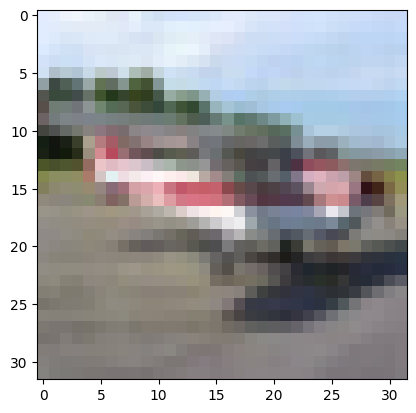

In [7]:
def show_image(img,label):
    print('Label: ', dataset.classes[label],"("+str(label)+")")
    plt.imshow(img.permute(1,2,0))

show_image(dataset[222][0],dataset[222][1])

### Training and Validation 

Let's ensure the reproducibility of the results, that is, that by executing the same code several times the same results are always obtained.

In [8]:
random_seed=42
torch.manual_seed(random_seed)

Let's define the size of the validation set (in this case, 5000 images).

In [9]:
val_size = 5000
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset,[train_size, val_size],generator=torch.manual_seed(random_seed))
len(train_ds), len(val_ds)

(45000, 5000)

**We calculate the size of the training set by subtracting the size of the validation set from the total length of the original dataset**. This ensures that the training set contains the rest of the images.

```random_split``` splits the original dataset into two subdatasets: one for training (```train_ds```) and one for validation (```val_ds```).

If the original dataset has, for example, 50,000 images:

- The training set (train_ds) will contain 45,000 images.
- The validation set (val_ds) will contain 5,000 images.

In [10]:
batch_size=128
train_dl = DataLoader(train_ds,batch_size,shuffle=True,num_workers=4,pin_memory=True )
val_dl = DataLoader(val_ds, batch_size, num_workers=4, pin_memory=True)

We define a batch size (the number of images that will be processed simultaneously in each training phase) of 128 images.

- ```shuffle=True```: This option shuffles the data at each epoch, which helps improve model generalization and prevents the model from fitting to a particular order of data.
- ```num_workers=4```: Sets the number of parallel processes used to load data. Using more processes helps speed up data loading, especially on large datasets. The ideal number of workers depends on the CPU and available memory.
- ```pin_memory=True```: When pin_memory=True, PyTorch pins memory to the CPU, which makes data transfer to the GPU faster.

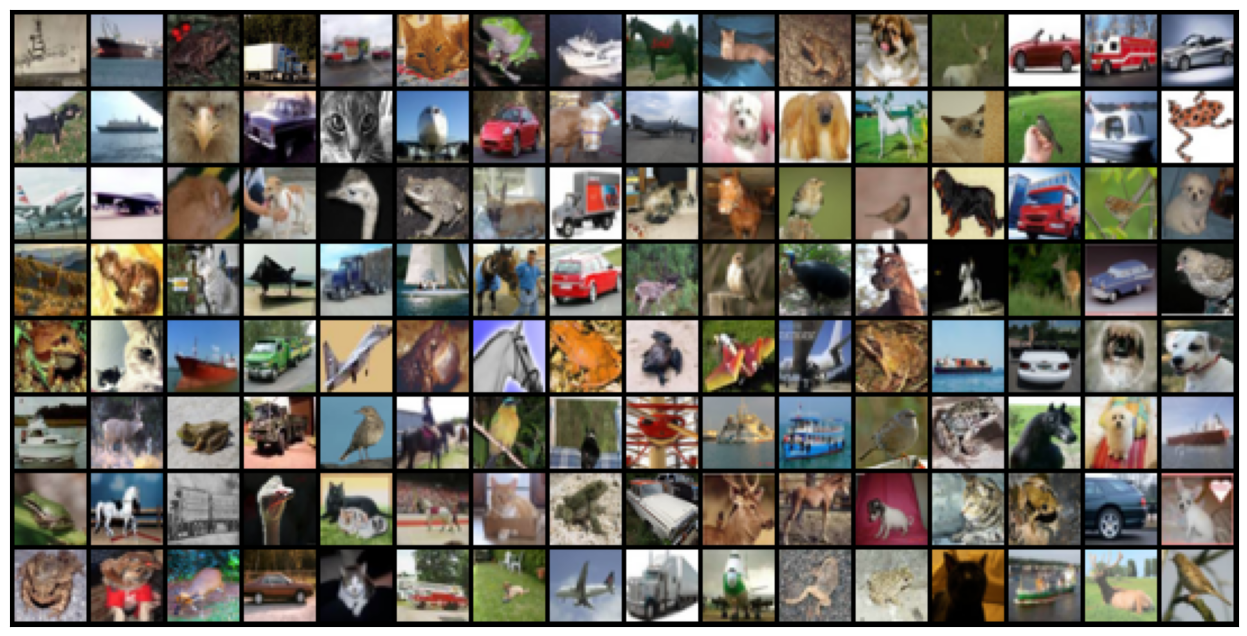

In [11]:
def show_images_batch(d1):
    for images, labels in d1:
        fig, ax= plt.subplots(figsize=(16,8))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1,2,0))
        break # to stop loop otherwise 4500 images in batch size of 128 will print and is computationally expensive

show_images_batch(train_dl) # training data single batch images

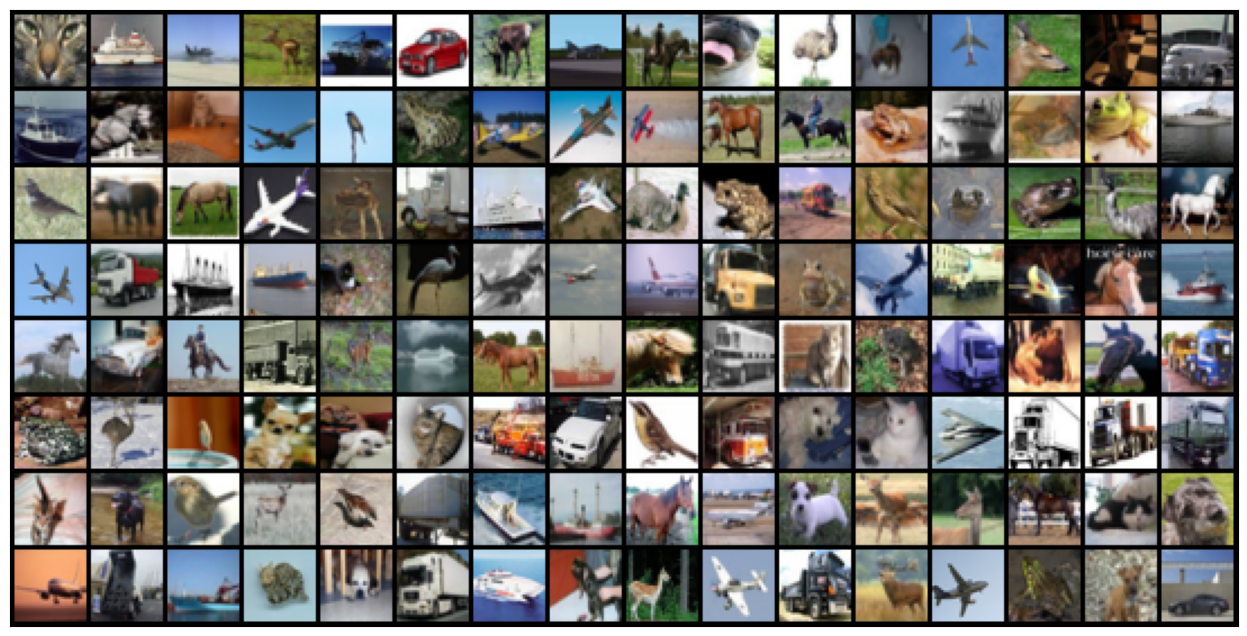

In [12]:
show_images_batch(val_dl) # validation data single batch images

### CNN Model

- ```accuracy```: **Takes as input the predictions (outputs) and the real labels (labels), exploiting ```torch.max``` to find the maximum value for each output and determine the predicted class**. It returns the percentage of correct predictions by comparing the predictions with the real labels.
- ```ImageClassificationBase```: This is a base class that will be used as a framework to build the classification model.
    - ```training_step```: Takes a batch of images and labels, passes the images through the model to get predictions, and **calculates the loss using the ```cross_entropy``` function**.
    - ```validation_step```: Similar to the training step, but used during the validation phase.
    - ```validation_epoch_end```: Takes the output of all validation batches of an epoch and **combines all the losses and accuracies of the batches to calculate the average loss and average accuracy of the epoch**.


In [13]:
def accuracy(outputs,labels):
    _,preds= torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds==labels).item()/len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self,batch):
        images,labels= batch
        out= self(images)  #Generate predictions
        loss= F.cross_entropy(out,labels) #calculate loss
        return loss
    
    def validation_step(self,batch):
        images, labels = batch
        out = self(images)  # Generate predictions
        loss= F.cross_entropy(out,labels) # calculate loss
        acc= accuracy(out,labels)
        return {'val_loss':loss.detach(), 'val_acc':acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss= torch.stack(batch_losses).mean() # Stacking losses to combine losses and calculate average
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean() # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
        
    def epoch_end(self,epoch,result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

**1. Convolutional blocks**:

3 blocks, each composed of 2 Conv2d convolutions, with ReLU activations.
After every second convolutional layer there is a MaxPool2d pooling layer that halves the spatial dimensions of the image.
At the end of the convolutional block, the dimensions are reduced from 32x32 to 4x4 with 256 feature maps.

**2. Fully-connected blocks**:

The Flatten layer converts the convolutional output (256 x 4 x 4) into a flat vector of 4096 elements.
There are 2 fully-connected layers with 1024 and 512 neurons respectively, followed by ReLU for nonlinear activations.
The last fully-connected layer has 10 neurons, one for each of the classes of the CIFAR-10 dataset.

In [14]:
class Cifar10CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
        
    def forward(self, xb):
        return self.network(xb)

In [15]:
model= Cifar10CnnModel()
model

Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_feat

This function automatically chooses the device to work on. If a GPU (CUDA) is available, it selects cuda, otherwise it uses the CPU.

In [16]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

This function moves tensors (or a list/tuple of tensors) to the specified device (CPU or GPU).
**Non-blocking transfer**: The ```non_blocking=True``` parameter allows data transfer to be performed in parallel with other operations, reducing bottlenecks (but only works if the data memory is "pinned" to the GPU).

In [17]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

DeviceDataLoader: class that wraps a **standard DataLoader** in PyTorch **to automatically transfer batches of data to the specified device**.

- ```__init__()```: Takes the original DataLoader (dl) and the device (device) as input.
- ```__iter__()```: When iterating over the DeviceDataLoader, this function is called, which transfers each batch of data to the device before returning it. This way, each batch of images and labels will be automatically loaded to the GPU (or CPU, depending on the device).
- ```__len__()```: Returns the length of the original DataLoader, i.e. how many batches of data it contains.

In [18]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [19]:
device = get_default_device()
device

device(type='cuda')

In [20]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device) 
to_device(model, device) 

Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_feat

### Training the Model

This snippet of code defines two important functions for training and evaluating a model: **evaluate and fit**.

- ```@torch.no_grad()```: It turns off automatic gradient calculation inside the function. It is used during evaluation to save memory and speed up the calculation, since gradients do not need to be stored during evaluation (unlike during training).
- ```model.eval()```: Puts the model into evaluation mode. This changes the behavior of some layers such as Dropout and BatchNorm, which behave differently in evaluation than in training. For example, Dropout does not randomly turn off neurons in evaluation.

For each batch in the validation dataloader, the model's validation step method is called, which calculates the batch's loss and accuracy.
These results are collected in the outputs list, which is then aggregated and returned via ```validation_epoch_end```.

In [23]:
@torch.no_grad() 
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)
  
def fit(epochs, lr, model, train_loader, val_loader, opt_func= torch.optim.SGD):
    # epochs: Number of training epochs (cycles).
    # lr: Learning rate for the optimizer.
    # model: The model being trained.
    # train_loader: The dataloader containing the training data.
    # val_loader: The dataloader containing the validation data.
    # opt_func: Optimizer function. Here we use SGD (Stochastic Gradient Descent) as default, but you can use any other optimizer (e.g. Adam).

    history=[]
    optimizer= opt_func(model.parameters(),lr) 
    for epoch in range(epochs):
        model.train() 
        train_losses=[]
        for batch in train_loader:
            loss= model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        result= evaluate(model,val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [25]:
num_epochs = 15
opt_func = torch.optim.Adam
lr = 0.001

In [26]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 1.7408, val_loss: 1.4818, val_acc: 0.4586
Epoch [1], train_loss: 1.2378, val_loss: 1.0751, val_acc: 0.6115
Epoch [2], train_loss: 0.9789, val_loss: 0.8862, val_acc: 0.6910
Epoch [3], train_loss: 0.8123, val_loss: 0.8543, val_acc: 0.7010
Epoch [4], train_loss: 0.6931, val_loss: 0.7536, val_acc: 0.7326
Epoch [5], train_loss: 0.5763, val_loss: 0.7195, val_acc: 0.7500
Epoch [6], train_loss: 0.4821, val_loss: 0.7058, val_acc: 0.7643
Epoch [7], train_loss: 0.3971, val_loss: 0.7222, val_acc: 0.7721
Epoch [8], train_loss: 0.3142, val_loss: 0.7701, val_acc: 0.7740
Epoch [9], train_loss: 0.2463, val_loss: 0.8262, val_acc: 0.7652
Epoch [10], train_loss: 0.1896, val_loss: 0.9779, val_acc: 0.7535
Epoch [11], train_loss: 0.1551, val_loss: 0.9954, val_acc: 0.7689
Epoch [12], train_loss: 0.1372, val_loss: 1.0853, val_acc: 0.7615
Epoch [13], train_loss: 0.1032, val_loss: 1.1235, val_acc: 0.7723
Epoch [14], train_loss: 0.0993, val_loss: 1.1641, val_acc: 0.7795


After only two epochs, the validation accuracy has already improved significantly, from 45.86% to 61.15%. This is a good sign, indicating that the model is learning effectively.

### Plotting 

In [27]:
def plot_accuracies(history):
    accuracies=[x['val_acc'] for x in history]
    plt.plot(accuracies,'-x')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs No of epochs')

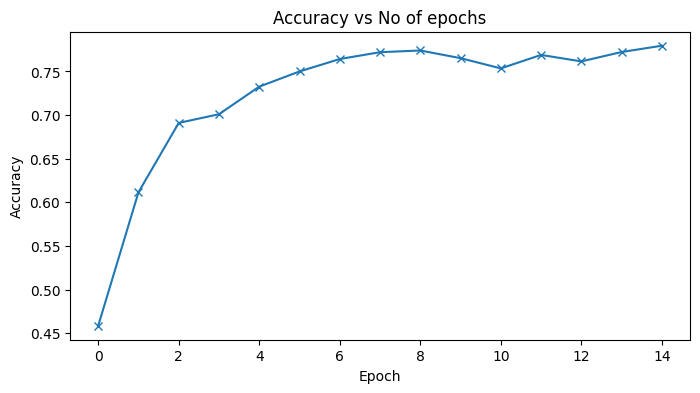

In [29]:
plt.figure(figsize=(8,4))
plot_accuracies(history)

In [30]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')

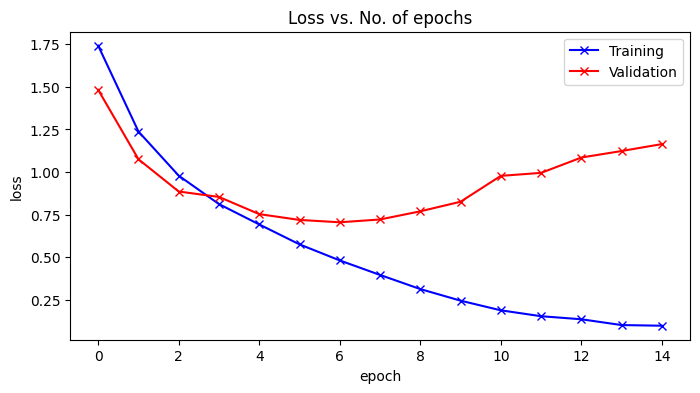

In [31]:
plt.figure(figsize=(8,4))
plot_losses(history)

### Testing with Test Set Images

In [ ]:
test_dataset = ImageFolder("../Object Detenction/input/cifar10/test", transform=ToTensor())
test_dataset

Dataset ImageFolder
    Number of datapoints: 10000
    Root location: /home/pierluigi/Documents/datasets/Object Detenction/input/cifar10/test
    StandardTransform
Transform: ToTensor()

Let's test the trained CNN model on images taken from the test dataset.

- ```img.unsqueeze(0)```: Adds one more dimension to the image to create a batch of size 1, since the CNN model expects a batch of images as input. So, even a single image must be in this format.

In [34]:
def predict_image(img, model):
    xb= to_device(img.unsqueeze(0),device)
    yb = model(xb) # makes a prediction by passing the image through the model

    _, preds= torch.max(yb, dim=1) # select the class with the highest probability
    return dataset.classes[preds[0].item()]

Label: airplane , Predicted: airplane


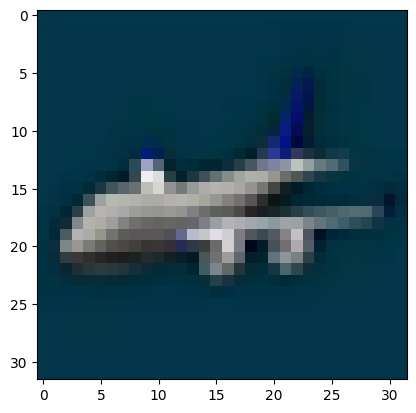

In [35]:
img,label= test_dataset[8]
plt.imshow(img.permute(1,2,0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: automobile , Predicted: automobile


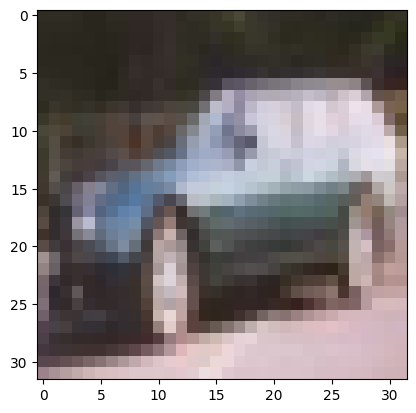

In [36]:
img,label= test_dataset[1220]
plt.imshow(img.permute(1,2,0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [37]:
test_loader=DeviceDataLoader(DataLoader(test_dataset,batch_size),device)
test_result = evaluate(model, test_loader)
test_result

{'val_loss': 1.211545705795288, 'val_acc': 0.7717563509941101}

In [40]:
torch.save(model.state_dict(), "object_recognition_model.pth")

In [ ]:
# to load the model
# Creare una nuova istanza del modello
# loaded_model = Cifar10CnnModel()

# # Caricare i pesi salvati
# loaded_model.load_state_dict(torch.load(model_path))

# # Spostare il modello sul device appropriato (es. GPU se disponibile)
# loaded_model = loaded_model.to(device)
